# Лабораторная работа №5 “Метод опорных векторов”

### *Набор данных **ex5data1.mat** представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит три переменные X<sub>1</sub> и X<sub><sub>1</sub></sub> (независимые переменные) и y (метка класса). Данные являются линейно разделимыми.*
### *Набор данных **ex5data2.mat** представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит три переменные X<sub>1</sub> и X<sub>2</sub> (независимые переменные) и y (метка класса). Данные являются нелинейно разделимыми.*
### *Набор данных **ex5data3.mat** представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит три переменные X<sub>1</sub> и X<sub>2</sub> (независимые переменные) и y (метка класса). Данные разделены на две выборки: обучающая выборка (X, y), по которой определяются параметры модели; валидационная выборка (Xval, yval), на которой настраивается коэффициент регуляризации и параметры Гауссового ядра.*
### *Набор данных **spamTrain.mat** представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит две переменные X - вектор, кодирующий отсутствие (0) или присутствие (1) слова из словаря vocab.txt в письме, и y - метка класса: 0 - не спам, 1 - спам. Набор используется для обучения классификатора.*
### *Набор данных **spamTest.mat** представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит две переменные Xtest - вектор, кодирующий отсутствие (0) или присутствие (1) слова из словаря vocab.txt в письме, и ytest - метка класса: 0 - не спам, 1 - спам. Набор используется для проверки качества классификатора.*

## **Задание**

### 1. Загрузите данные **ex5data1.mat** из файла.

In [2]:
import re
import email
import os

import pandas as pd
import numpy as np

from scipy import io
from sklearn.svm import SVC

from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
ex5data1 = io.loadmat('Data/Lab 5/ex5data1.mat')
ex5data1_df = pd.DataFrame(ex5data1['X'], columns=['x1', 'x2'])
ex5data1_df['y'] = ex5data1['y']

### 2. Постройте график для загруженного набора данных: по осям - переменные X1, X2, а точки, принадлежащие различным классам должны быть обозначены различными маркерами.

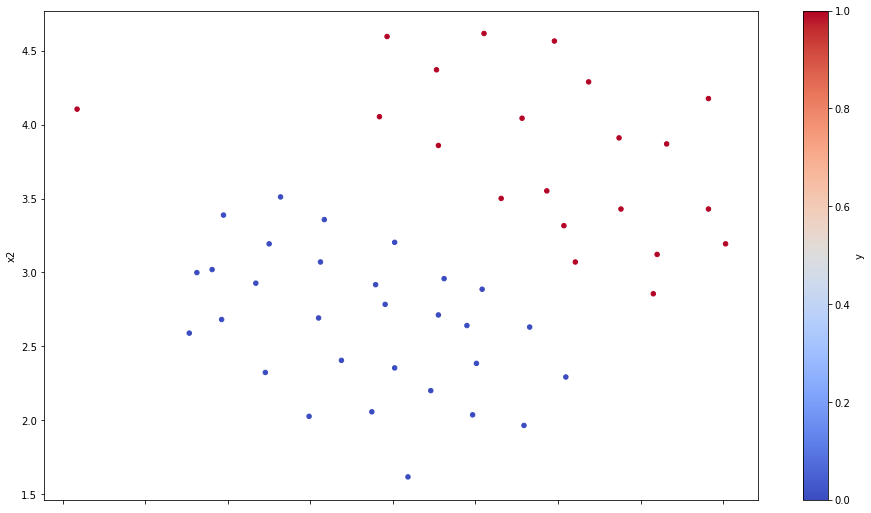

In [4]:
ex5data1_df.plot(kind='scatter', x='x1', y='x2', c='y', cmap='coolwarm', figsize=(16,9))

### 3. Обучите классификатор с помощью библиотечной реализации SVM с линейным ядром на данном наборе.

In [5]:
svc_c1 = SVC(kernel='linear', C=1)
svc_c1.fit(ex5data1_df[['x1', 'x2']], ex5data1_df['y'])

svc_c100 = SVC(kernel='linear', C=100)
svc_c100.fit(ex5data1_df[['x1', 'x2']], ex5data1_df['y'])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

### 4. Постройте разделяющую прямую для классификаторов с различными параметрами C = 1, C = 100 (совместно с графиком из пункта 2). Объясните различия в полученных прямых?

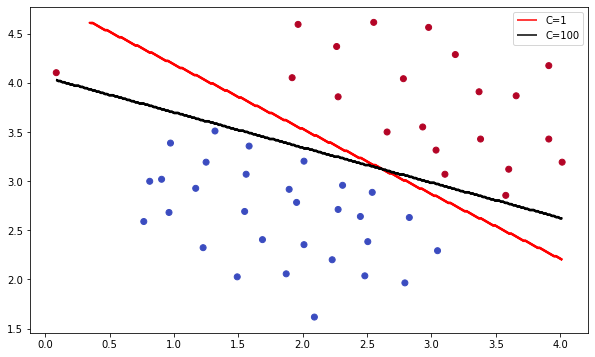

In [12]:
def get_meshgrid(x1, x2, n=250):
    l1 = np.linspace(x1.min(), x1.max(), n).T
    l2 = np.linspace(x2.min(), x2.max(), n).T
    return np.meshgrid(l1, l2)

xx1, xx2 = get_meshgrid(ex5data1_df['x1'], ex5data1_df['x2'])

svc_c1_pred = svc_c1.predict(np.c_[xx1.ravel(), xx2.ravel()])
svc_c100_pred = svc_c100.predict(np.c_[xx1.ravel(), xx2.ravel()])

fig, ax = plt.subplots(figsize=(10,6))

plt.scatter(x=ex5data1_df['x1'], y=ex5data1_df['x2'], 
            c=ex5data1_df['y'], 
            cmap='coolwarm')

con1 = ax.contour(xx1, xx2, svc_c1_pred.reshape(xx1.shape), colors='red')
con100 = ax.contour(xx1, xx2, svc_c100_pred.reshape(xx1.shape), colors='black')

lines = [ con1.collections[0], con100.collections[0]]
labels = ['C=1','C=100']

plt.legend(lines, labels)

Данный параметр помогает отрегулировать ту тонкую грань между “гладкостью” и точностью классификации объектов обучающей выборки. Чем больше значение “С” тем больше объектов обучающей выборки будут правильно классифицированы.

### 5. Реализуйте функцию вычисления Гауссового ядра для алгоритма SVM.

In [13]:
# функция Гауссова ядра (дальше нужно оптимизировать sigma квадрат, а не просто sigma, поэтому s=sigma^2)
def gauss_kernel(x1, x2, s=0.01):
    x1 = x1.flatten()
    x2 = x2.flatten()
    return np.exp(- np.sum( np.power((x1 - x2),2) ) / (2.0*s))

### 6. Загрузите данные **ex5data2.mat** из файла.

In [14]:
ex5data2 = io.loadmat('Data/Lab 5/ex5data2.mat')
ex5data2_df = pd.DataFrame(ex5data2['X'], columns=['x1', 'x2'])
ex5data2_df['y'] = ex5data2['y']

### 7. Обработайте данные с помощью функции Гауссового ядра.

In [15]:
def gauss_kernel_preprocess(X1, X2, s=0.01):
    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            gram_matrix[i, j] = gauss_kernel(x1, x2, s)
    return gram_matrix

preprocessed_data = gauss_kernel_preprocess(ex5data2['X'], ex5data2['X'])

### 8. Обучите классификатор SVM.

In [16]:
svc2 = SVC(C=100, kernel='precomputed')
svc2.fit(preprocessed_data, ex5data2['y'])

/home/z_ermak/miniconda3/envs/bsuir_labs/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='precomputed', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

### 9. Визуализируйте данные вместе с разделяющей кривой (аналогично пункту 4).

/home/z_ermak/miniconda3/envs/bsuir_labs/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


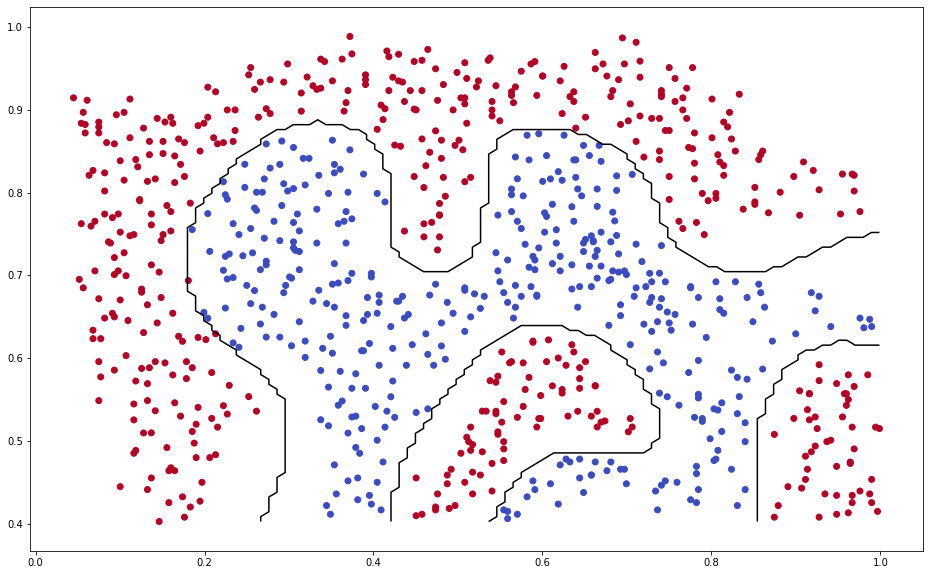

In [18]:
xx1, xx2 = get_meshgrid(ex5data2_df['x1'], ex5data2_df['x2'], 100)
preds = np.zeros(xx1.shape)
for i in range(xx1.shape[1]):
    new_X = np.column_stack((xx1[:, i], xx2[:, i]))
    preds[:, i] = svc2.predict(gauss_kernel_preprocess(new_X, ex5data2['X']))


plt.figure(figsize=(16, 10))
plt.scatter(x=ex5data2_df['x1'], y=ex5data2_df['x2'], 
            c=ex5data2_df['y'], 
            cmap='coolwarm')
plt.contour(xx1, xx2, preds, colors='black', levels=[0,0])

### 10. Загрузите данные **ex5data3.mat** из файла.

In [19]:
ex5data3 = io.loadmat('Data/Lab 5/ex5data3.mat')
X, Xval, y, yval = (ex5data3['X'], ex5data3['Xval'],
                    ex5data3['y'].flatten(),
                    ex5data3['yval'].flatten())

### 11. Вычислите параметры классификатора SVM на обучающей выборке, а также подберите параметры C и σ<sup>2</sup> на валидационной выборке.

In [22]:
def select_best_model(X, Xval, y, yval):
    preprocessed_fit_data = gauss_kernel_preprocess(X, X)
    best_svc = None
    min_number_of_errors = len(yval)

    for C in (0.01, 1, 10, 25, 100):
        for s in (0.0001, 0.0025, 0.01, 0.25, 1, 25):

            svc3 = SVC(C=C, kernel='precomputed')
            svc3.fit(preprocessed_fit_data, y)

            # compute predictions on cross-validation set
            predictions = svc3.predict(gauss_kernel_preprocess(Xval, X, s))
            number_of_errors = sum(predictions != yval)

            if number_of_errors < min_number_of_errors:
                best_svc = svc3
                min_number_of_errors = number_of_errors

            print('C={}, s={}, num of errors = {}'.format(
                C, s, sum(predictions != yval)
            ))
            
    return best_svc

best_svc = select_best_model(X, Xval, y, yval)

C=0.01, s=0.0001, num of errors = 113
C=0.01, s=0.0025, num of errors = 113
C=0.01, s=0.01, num of errors = 113
C=0.01, s=0.25, num of errors = 113
C=0.01, s=1, num of errors = 113
C=0.01, s=25, num of errors = 113
C=1, s=0.0001, num of errors = 106
C=1, s=0.0025, num of errors = 31
C=1, s=0.01, num of errors = 7
C=1, s=0.25, num of errors = 22
C=1, s=1, num of errors = 24
C=1, s=25, num of errors = 48
C=10, s=0.0001, num of errors = 107
C=10, s=0.0025, num of errors = 48
C=10, s=0.01, num of errors = 12
C=10, s=0.25, num of errors = 17
C=10, s=1, num of errors = 17
C=10, s=25, num of errors = 54
C=25, s=0.0001, num of errors = 106
C=25, s=0.0025, num of errors = 56
C=25, s=0.01, num of errors = 12
C=25, s=0.25, num of errors = 16
C=25, s=1, num of errors = 16
C=25, s=25, num of errors = 65
C=100, s=0.0001, num of errors = 105
C=100, s=0.0025, num of errors = 44
C=100, s=0.01, num of errors = 12
C=100, s=0.25, num of errors = 15
C=100, s=1, num of errors = 17
C=100, s=25, num of errors

### 12. Визуализируйте данные вместе с разделяющей кривой (аналогично пункту 4).

/home/z_ermak/miniconda3/envs/bsuir_labs/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


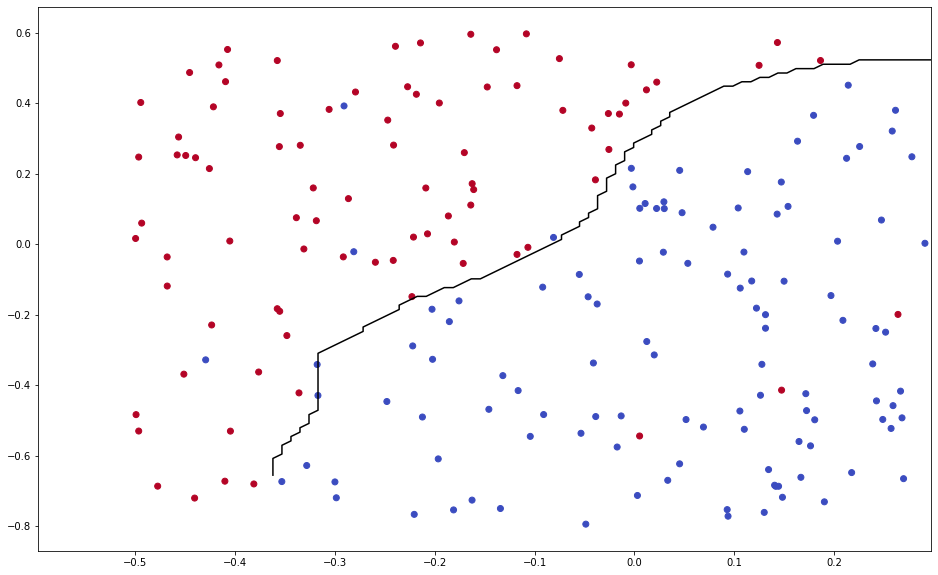

In [23]:
xx1, xx2 = get_meshgrid(X[:,0], X[:,1], 100)
preds = np.zeros(xx1.shape)
for i in range(xx1.shape[1]):
    new_X = np.column_stack((xx1[:, i], xx2[:, i]))
    preds[:, i] = best_svc.predict(gauss_kernel_preprocess(new_X, X))


plt.figure(figsize=(16, 10))
plt.scatter(x=Xval[:,0], y=Xval[:,1], 
            c=yval, 
            cmap='coolwarm')
plt.contour(xx1, xx2, preds, colors='black', levels=[0,0])

### 13. Загрузите данные **spamTrain.mat** из файла.

In [24]:
spam_train = io.loadmat('Data/Lab 5/spamTrain.mat')

### 14. Обучите классификатор SVM.

In [ ]:
preprocessed_data = gauss_kernel_preprocess(spam_train['X'], spam_train['X'])

In [26]:
svc_spam = SVC(C=100, kernel='linear')
svc_spam.fit(spam_train['X'], spam_train['y'].flatten())

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

### 15. Загрузите данные **spamTest.mat** из файла.

In [27]:
spam_test = io.loadmat('Data/Lab 5/spamTest.mat')

### 16. Подберите параметры C и σ<sup>2</sup>.

In [ ]:
select_best_model(spam_train['X'], 
                  spam_train['y'].flatten(), 
                  spam_test['Xtest'],
                  spam_test['ytest'].flatten())

In [39]:
predictions = svc_spam.predict(spam_test['Xtest'])

print('number of test examples: {}, number of incorrect predictions: {}'.format(
    len(spam_test['ytest']), sum(predictions != spam_test['ytest'].flatten())
))

number of test examples: 1000, number of incorrect predictions: 30


### 17. Реализуйте функцию предобработки текста письма, включающую в себя:
### -перевод в нижний регистр;
### -удаление HTML тэгов;
### -замена URL на одно слово (например, “httpaddr”);
### -замена email-адресов на одно слово (например, “emailaddr”);
### -замена чисел на одно слово (например, “number”);
### -замена знаков доллара ($) на слово “dollar”;
### -замена форм слов на исходное слово (например, слова “discount”, “discounts”, “discounted”, “discounting” должны быть заменены на слово “discount”). Такой подход называется stemming;
### -остальные символы должны быть удалены и заменены на пробелы, т.е. в результате получится текст, состоящий из слов, разделенных пробелами.


In [30]:
def email_preprocess(email_text):
    email_text = email_text.lower()
    email_text = re.sub('<[^<>]+>', ' ', email_text)
    email_text = re.sub('[0-9]+', 'number', email_text)
    email_text = re.sub('(http|https)://[^\s]*', 'httpaddr', email_text)
    email_text = re.sub('[^\s]+@[^\s]+', 'emailaddr', email_text)
    email_text = re.sub('[$]+', 'dollar', email_text)
    email_text = re.split(r'[@$/#.-:&\*\+=\[\]?!(){},\'\'\">_<;%\s\n\r\t]+', email_text)
    
    return [PorterStemmer().stem(token.strip()) for token in email_text if len(token) > 1]

### 18. Загрузите коды слов из словаря **vocab.txt**.

In [31]:
with open('Data/Lab 5/vocab.txt', 'r') as f:
    vocab = {}
    
    for line in f.readlines():
        i, word = line.split()
        vocab[word] = int(i)

### 19. Реализуйте функцию замены слов в тексте письма после предобработки на их соответствующие коды.

In [32]:
def replace_words_with_codes(email_text, vocab):
    return [vocab[i] for i in email_preprocess(email_text) if vocab.get(i)]

### 20. Реализуйте функцию преобразования текста письма в вектор признаков (в таком же формате как в файлах **spamTrain.mat** и **spamTest.mat**).

In [33]:
def make_vector(codes, vocab):
    vector = np.zeros(len(vocab))
    for i in codes:
        vector[i-1] = 1
        
    return vector

### 21. Проверьте работу классификатора на письмах из файлов **emailSample1.txt**, **emailSample2.txt**, **spamSample1.txt** и **spamSample2.txt**.

In [46]:
def get_email_features(f_name):
    with open(f_name) as f:
        email_text = ''.join(f.readlines())

        return make_vector(replace_words_with_codes(email_text, vocab), vocab)
    
print(
    'email sample1 prediction: {}'.format(
        svc_spam.predict([get_email_features('Data/Lab 5/emailSample1.txt')])[0]
    ),
    '\nemail sample2 prediction: {}'.format(
      svc_spam.predict([get_email_features('Data/Lab 5/emailSample2.txt')])[0]
    ),
    '\nspam sample1 prediction: {}'.format(
      svc_spam.predict([get_email_features('Data/Lab 5/spamSample1.txt')])[0]
    ),
    '\nspam sample2 prediction: {}'.format(
      svc_spam.predict([get_email_features('Data/Lab 5/spamSample2.txt')])[0]
    )
)

email sample1 prediction: 0 
email sample2 prediction: 0 
spam sample1 prediction: 1 
spam sample2 prediction: 1


### 22. Также можете проверить его работу на собственных примерах.

In [48]:
print(
    'my email prediction: {}'.format(
        svc_spam.predict([get_email_features('Data/Lab 5/myEmailSample.txt')])[0]
    ),
    '\nmy spam prediction: {}'.format(
      svc_spam.predict([get_email_features('Data/Lab 5/mySpamSampe.txt')])[0]
    )
)

my email prediction: 0 
my spam prediction: 1


### 23. Создайте свой набор данных из оригинального корпуса текстов - http://spamassassin.apache.org/old/publiccorpus/.

In [ ]:
def make_emails_list(path):
    emails = []
    
    for i in os.listdir(path):
        with open(os.path.join(path, i)) as f:
            try:
                email_data = email.message_from_string(''.join(f.readlines()))
                
                if isinstance(email_data.get_payload(), str):
                    email_text = email_data.get_payload()
                    emails.append(email_text)
            except:
                print('error while parse email')
            
    return emails

spams = make_emails_list('Data/Lab 5/spam/')
emails = make_emails_list('Data/Lab 5/easy_ham/')

### 24. Постройте собственный словарь.

In [37]:
new_vocab = {}

### 25. Как изменилось качество классификации? Почему?

In [49]:
def test_vocab(vocab, examples, label):
    print('number of examples: {}'.format(len(examples)))
    
    features = list(map(
        lambda x: make_vector(replace_words_with_codes(x, vocab), 
                              vocab),
        examples
    ))
    
    incorrect_count = sum(svc_spam.predict(features) != label)
    
    print('number of incorrect predictions: {}'.format(incorrect_count))

print('old vocab')
print('for emails:')
test_vocab(vocab, emails, 0)

print('old vocab')
print('for spams:')
test_vocab(vocab, spams, 1)

print('new vocab')
print('for emails:')
test_vocab(new_vocab, emails, 0)

print('new vocab')
print('for spams:')
test_vocab(new_vocab, spams, 1)

old vocab
for emails:
number of examples: 2314
number of incorrect predictions: 34
old vocab
for spams:
number of examples: 334
number of incorrect predictions: 6
new vocab
for emails:
number of examples: 2314
number of incorrect predictions: 34
new vocab
for spams:
number of examples: 334
number of incorrect predictions: 6
